## Summary

One in nine Americans age 65 and older will suffer from Alzheimer's Disease (AD) related dementia. AD is a progressive condition and early detection is vital to arresting the development of the disease. When an elderly patient begins exhibiting what might be considered abnormal cognitive decline, a doctor will order an MRI to see if there are any signs of atrophy in the brain. At early stages of dementia, however, these signs may not be obviously apparent to even the trained eye and cases can be misdiagnosed. As a hospital system that serves a large elderly population, the University of Florida Health System would like to improve the accuracy of their dementia diagnoses be incorporating machine learning into the process. My solution is to build an image classification system that can read MRIs and identify them as either normal or demented with a high degree of accuracy. To do this, I used two unique datasets. The first included RAW (unprocessed) MRI images from 150 patients enrolled in a dementia study provided by the Open Access Series of Imaging Studies (OASIS). The second dataset contains 6,500 images of preprocessed MRIs provided by the Alzheimer’s Disease Neuroimaging Initiative (ADNI). Both datasets includes labeled images for both normal and dementia patients that could be fed to a convolutional neural network (CNN) for classification. Results for each model were measured in terms of accuracy and cross entropy loss. Overall, the preprocessed data performed much better than the RAW images. The best RAW model achieved a test accuracy of 55% in a binary (dementia or normal) classification problem. The best preprocessed model achieved a test accuracy of 98.9% using four classes ranging from Normal to Moderately Demented patients. My results show the power of standard neuroimaging preprocessing in isolating the impact areas of the brain for analyses such as this. Using preprocessed images with a CNN, like the onen outlined in this notebook, can allow doctors to identify dementia in patients from a very early stage so they can begin treatmenmt. My recommendation to the stakeholders would be to make this tool available to their doctors to assist in diagnosing as well as implement a preprocessing pipeline to streamline the production of model ready images. If I had more time, I would have liked to try to work with the RAW images as 3D structures rather than 2D slices. I attempted to do so, but ran into memory constraints while importing the data. With more time, I would have liked to explore the option further as a way to work with the RAW images and save our stakeholders the time and expense of preprocessing their images.        




In [3]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import seaborn as sns
from PIL import Image
import cv2

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise, BatchNormalization, Flatten, Conv2D, MaxPooling2D 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications import vgg16
from tensorflow.keras import regularizers
from tensorflow.keras.losses import BinaryCrossentropy
import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [5]:
#plot performance of training and validation metrics across epochs

def plot_performance(model_history):
    history = pd.DataFrame(model_history.history)
    history.index.name = 'Epochs'

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

    col_list1 = ['loss', 'val_loss']
    ax[0].plot(history.index, history[col_list1])
    ax[0].set_ylabel('Binary Cross Entropy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_title('Training and Validation Loss History')
    ax[0].legend(col_list1)

    col_list2 = ['accuracy', 'val_accuracy']
    ax[1].plot(history.index, history[col_list2])
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_title('Training and Validation Accuracy History')
    ax[1].legend(col_list2)

    return plt.show()



In [6]:
#evaluate model performance using test data and print metrics

def test_evaluation(test_generator, model):
    test_loss, test_accuracy = model.evaluate(test_generator, verbose = 1)
    print('Test loss: {} \nTest accuracy: {}'.format(test_loss, test_accuracy))

In [7]:
#get model predictions and plot in a confusion matrix and classification report for binary models

def binary_cm_cr(generator, model):
    predictions = model.predict_generator(generator)
    predicted_classes = np.round(predictions)
    true_classes = generator.classes
    cm = confusion_matrix(true_classes, predicted_classes)
    ConfusionMatrixDisplay(cm).plot()
    print(classification_report(true_classes, predicted_classes))

In [8]:
#get model predictions and plot in a confusion matrix and classification report for multicategorical models

def multicat_cm_cr(generator, model):
    predictions = model.predict_generator(generator)
    predicted_classes = np.argmax(predictions, axis = 1)
    true_classes = generator.classes
    cm = confusion_matrix(true_classes, predicted_classes)
    ConfusionMatrixDisplay(cm).plot()
    print(classification_report(true_classes, predicted_classes))

## Section 1 - RAW MRIs

First, I will examine the RAW MRIs. Preprocessing an MRI requires specialized packages that are not standardized. Technicians at different institutions will use different tools, leading to a fragmented knowledge base. If I can create a solution using RAW MRIs, I believe it would provide a large efficiency gain

## EDA/Data Visualization

In [7]:
#load MRI image using nibabel, a python package designed for reading nifti file types
nifti_file = nib.load('/Users/mike/Brain_MRI/Demented_MRI/OAS2_0002_MR1/RAW/mpr-1.nifti.img')

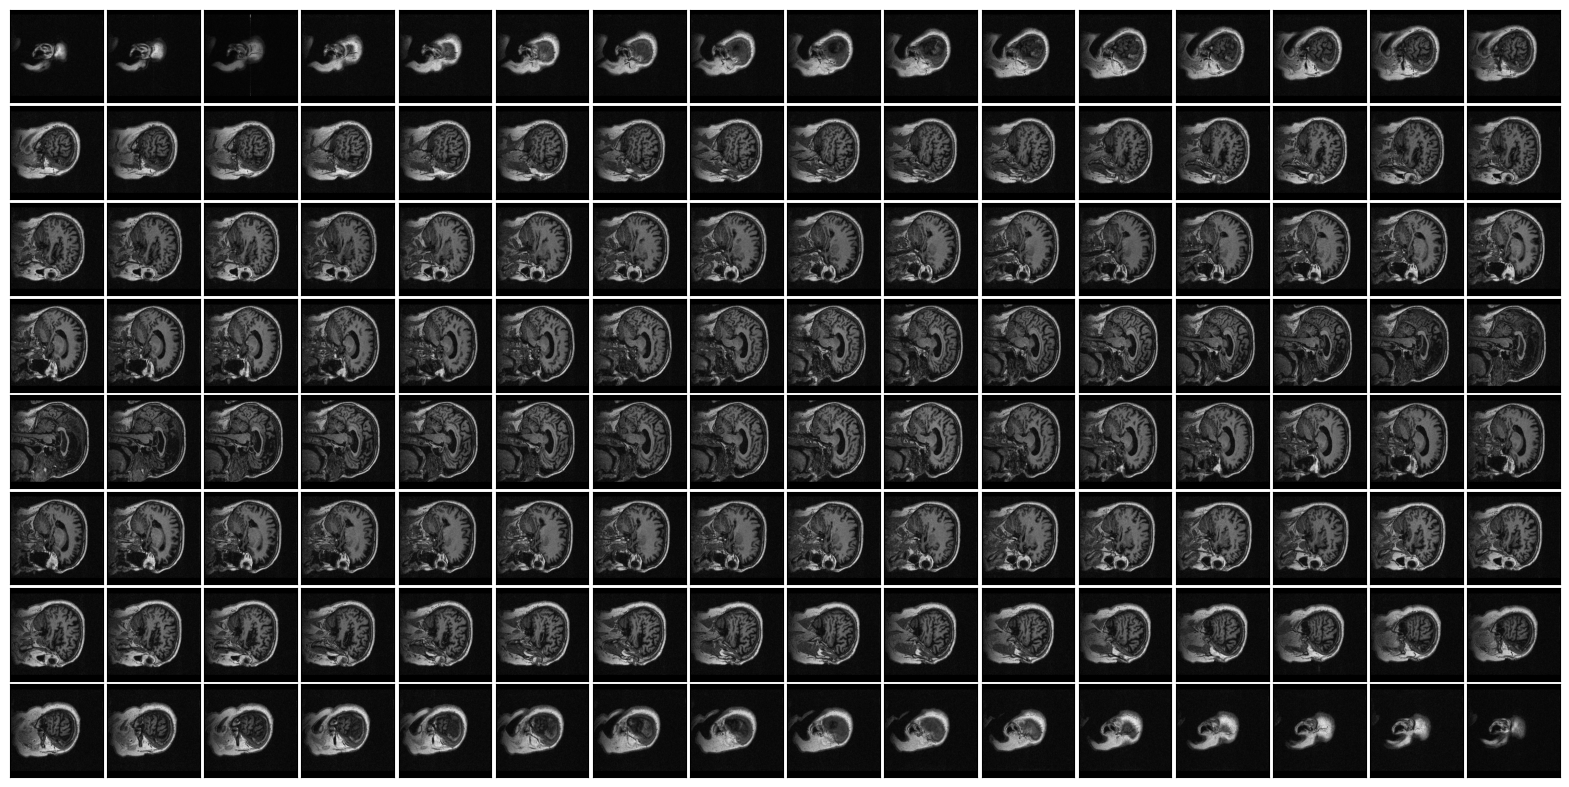

In [9]:
#get the underlying pixel values in array format
img_data = nifti_file.get_fdata()

# Create a grid to house the images 
fig, axes = plt.subplots(nrows = 8, ncols = 16, figsize=(20, 10))

# Flatten the axes array for indexing
axes = axes.ravel()

# Iterate over the 128 slices of the brain and show each one 
for i in range(img_data.shape[2]):
    img_slice = img_data[:, :, i, 0]
    axes[i].imshow(img_slice, cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.01)

# Show the plot
plt.show()

The images above show that each of the 128 slices of the MRI file shows a different depth of the brain. One issue we will encounter in using 2D images is identifying which slice of the brain dementia presents itself most clearly. My research indicated that precuneus and hippocampus atrophy are among the best biological indicators of Alzheimer's Disease (the leading cause of dementia). Both these ares are located towards the center of the brain, so for my analysis, I chose to run models using the center slice of the brain.

## Train-Test-Validation Split

The original study sample included 150 subjects: 72 cognitively normal subjects, 64 characterized as demented and  14 who began as cognitively normal and converted to demented over the course of the study. The converters were excluded since the exact scan the conversion was observed could not be determined. Of the reamining patients' scans, 10% were allocated to the validation set and 10% were allocated to the test set. The remaining subjects were used for training.

In [4]:
#import accompanying subject directory and remove converters
df = pd.read_excel('/Users/mike/Brain_MRI/oasis_longitudinal_demographics.xlsx')
df = df.loc[df['Group'] != 'Converted']

#establish demented and non-demented patient groups
demented_subjects = df['Subject ID'].loc[df['Group'] == 'Demented'].drop_duplicates('first').tolist()
nondemented_subjects = df['Subject ID'].loc[df['Group'] == 'Nondemented'].drop_duplicates('first').tolist()

#create reference lists for sorting dementia patients
test_dementia = demented_subjects[0:6]
val_dementia = demented_subjects[6:12]
train_dementia = demented_subjects[12:64]

#create reference lists for sorting non=dementia patients
test_nondementia = nondemented_subjects[0:7]
val_nondementia = nondemented_subjects[7:14]
train_nondementia = nondemented_subjects[14:72]

In [12]:
#scan images were sorted into train, test and validatio folders according to the lists above

#identify paths for train, validation and test sets
train_path = '/Users/mike/Brain_MRI/New Train'
val_path = '/Users/mike/Brain_MRI/New Validation'
test_path = '/Users/mike/Brain_MRI/New Test'

#generate image arrays and labels for train, validation and test using ImageDataGenerator

#train includes data augmentation with horizontal flip and random rotation 
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip = True, rotation_range = 20)
train_generator = train_datagen.flow_from_directory(train_path, target_size =(256,256), batch_size = 32,
                                                   class_mode = 'binary', color_mode='grayscale')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path, target_size =(256,256), batch_size = 32,
                                                  class_mode= 'binary', shuffle = False, color_mode='grayscale')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = train_datagen.flow_from_directory(val_path, target_size =(256,256), batch_size = 32,
                                                  class_mode= 'binary', shuffle = False, color_mode='grayscale')

Found 990 images belonging to 2 classes.
Found 121 images belonging to 2 classes.
Found 123 images belonging to 2 classes.


In [13]:
#confirm the key for generator class labels 
class_indices = train_generator.class_indices
class_indices

{'Dementia': 0, 'Nondementia': 1}

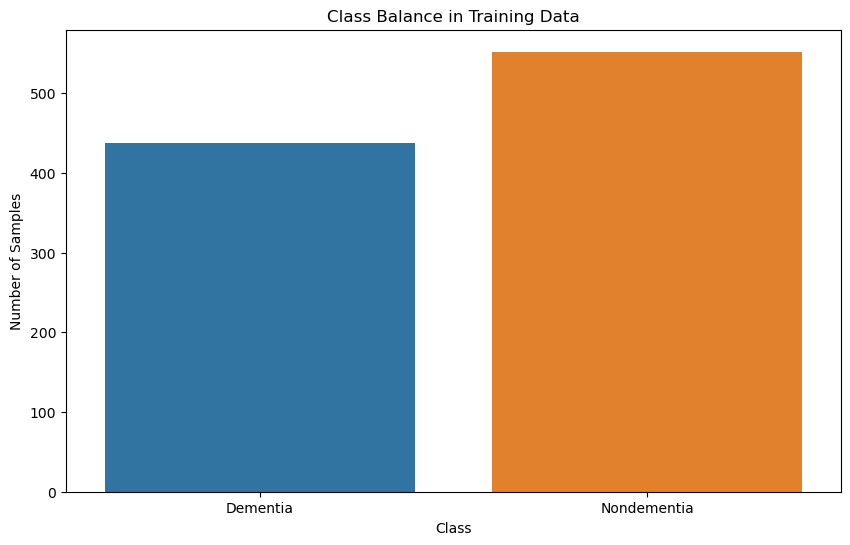

In [14]:
# Get the number of samples for each class
num_samples = []
for key in class_indices.keys():
    num_samples.append(len(train_generator.labels[train_generator.labels==class_indices[key]]))

# Create a bar chart to visualize the class balance
plt.figure(figsize=(10,6))
sns.barplot(x=list(class_indices.keys()), y=num_samples)
plt.title('Class Balance in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()


There is a slight class imbalance skewed towards the nondementia class. The difference is small, so I will leave the balance as is.

## Baseline Model

For the baseline model, I will use a simple CNN with two convolutional and one dense layer.

In [3]:
#instantiate a model
baseline_model = Sequential()


# add the input layer  
baseline_model.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(256, 256, 1)))

baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

# add the second convolutional layer
baseline_model.add(Conv2D(filters=16,
                        kernel_size=(3, 3),
                        activation='relu'))

baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers. output for binary classification
baseline_model.add(Flatten())
baseline_model.add(Dense(512, activation='relu'))
baseline_model.add(Dense(1, activation='sigmoid'))

#use early stopping to help prevent overfitting 
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
baseline_model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
history_base = baseline_model.fit(train_generator, validation_data = val_generator, epochs = 10, verbose = 1, callbacks = [early_stopping])

Metal device set to: Apple M1 Pro
Epoch 1/10
31/31 [==============================] - 5s 129ms/step - loss: 0.8368 - accuracy: 0.5515 - val_loss: 0.6933 - val_accuracy: 0.5854
Epoch 2/10
31/31 [==============================] - 4s 111ms/step - loss: 0.6672 - accuracy: 0.5879 - val_loss: 0.6742 - val_accuracy: 0.5691
Epoch 3/10
31/31 [==============================] - 3s 100ms/step - loss: 0.6200 - accuracy: 0.6495 - val_loss: 0.6576 - val_accuracy: 0.5447
Epoch 4/10
31/31 [==============================] - 3s 101ms/step - loss: 0.5656 - accuracy: 0.7061 - val_loss: 0.6581 - val_accuracy: 0.6260
Epoch 5/10
31/31 [==============================] - 3s 100ms/step - loss: 0.5221 - accuracy: 0.7485 - val_loss: 0.7103 - val_accuracy: 0.5854
Epoch 6/10
31/31 [==============================] - 3s 100ms/step - loss: 0.5057 - accuracy: 0.7626 - val_loss: 0.7757 - val_accuracy: 0.5366
Epoch 7/10
31/31 [==============================] - 3s 102ms/step - loss: 0.4388 - accuracy: 0.8051 - val_loss: 0.

In [9]:
#evaluate performance on test data
test_evaluation(test_generator, baseline_model)

4/4 [==============================] - 0s 39ms/step - loss: 1.4230 - accuracy: 0.4380
Test loss: 1.4230191707611084 
Test accuracy: 0.4380165636539459


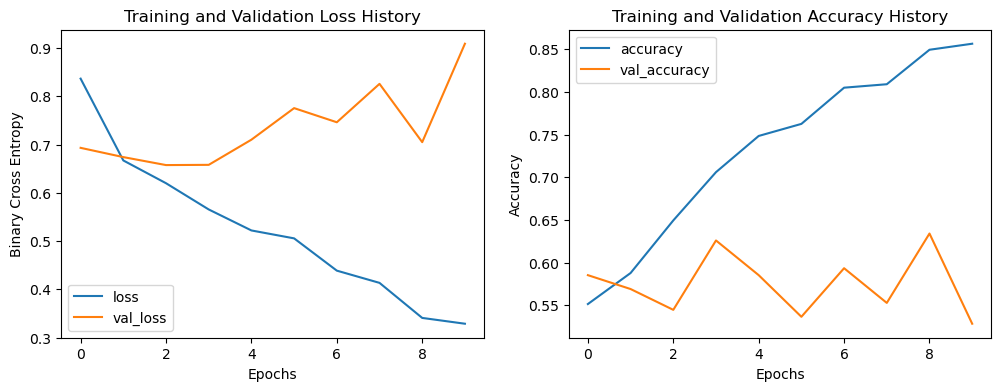

In [10]:
#visualize performance over training 
plot_performance(history_base)

              precision    recall  f1-score   support

           0       0.39      0.53      0.45        53
           1       0.50      0.37      0.42        68

    accuracy                           0.44       121
   macro avg       0.45      0.45      0.44       121
weighted avg       0.45      0.44      0.44       121



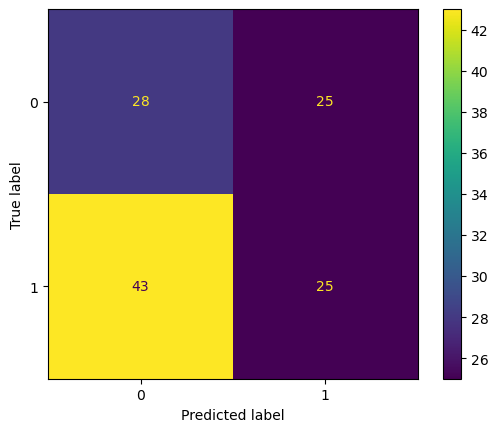

In [11]:
#dig into test performance more
binary_cm_cr(test_generator, baseline_model)

Baseline test accuracy and loss are 43% and 1.42 respectively. The model performs worse than random chance at identifying dementia from the RAW MRIs. Based on the visualizations of the traning vs validation performance, we can see that the model is clearly overfitting. There seems to be a consistent random trend in the validation accuracy. The test scores are also very different from the validation set which may be a sign the model is optimizing towards weights and not necessarily picking up on the patterns in the data.


## Model 1

In this model iteration, I will add more convolutional layers as well as dropout to my dense layer. The goal is to increase the level of detail the model captures, while trying to reduce some of the overfitting.

In [12]:
model_1 = Sequential()


# add the input layer  
model_1.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(256, 256, 1)))

model_1.add(MaxPooling2D(pool_size=(2, 2)))

# add the second convolutional layer
model_1.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2, 2)))

# add the third convolutional layer
model_1.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2, 2)))

# add the fourth convolutional layer
model_1.add(Conv2D(filters=16,
                        kernel_size=(3, 3),
                        activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2, 2)))


# connect all nodes with dense layers. output for binary classification
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(.5))
model_1.add(Dense(1, activation='sigmoid'))

#use early stopping to help prevent overfitting 
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_1.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
history_model_1 = model_1.fit(train_generator, validation_data = val_generator, epochs = 10, verbose = 1, callbacks = [early_stopping])

Epoch 1/10
31/31 [==============================] - 5s 135ms/step - loss: 0.6900 - accuracy: 0.5404 - val_loss: 0.6730 - val_accuracy: 0.5854
Epoch 2/10
31/31 [==============================] - 5s 147ms/step - loss: 0.6807 - accuracy: 0.5707 - val_loss: 0.6528 - val_accuracy: 0.5935
Epoch 3/10
31/31 [==============================] - 4s 136ms/step - loss: 0.6535 - accuracy: 0.6051 - val_loss: 0.6538 - val_accuracy: 0.5854
Epoch 4/10
31/31 [==============================] - 4s 114ms/step - loss: 0.6518 - accuracy: 0.6253 - val_loss: 0.6789 - val_accuracy: 0.5447
Epoch 5/10
31/31 [==============================] - 4s 112ms/step - loss: 0.6195 - accuracy: 0.6515 - val_loss: 0.6697 - val_accuracy: 0.6098
Epoch 6/10
31/31 [==============================] - 4s 112ms/step - loss: 0.6041 - accuracy: 0.6687 - val_loss: 0.7172 - val_accuracy: 0.5610
Epoch 7/10
31/31 [==============================] - 4s 112ms/step - loss: 0.5761 - accuracy: 0.7000 - val_loss: 0.6270 - val_accuracy: 0.6504
Epoch 

In [13]:
#evaluate performance on test data
test_evaluation(test_generator, model_1)

4/4 [==============================] - 0s 52ms/step - loss: 1.0051 - accuracy: 0.4050
Test loss: 1.0050673484802246 
Test accuracy: 0.40495869517326355


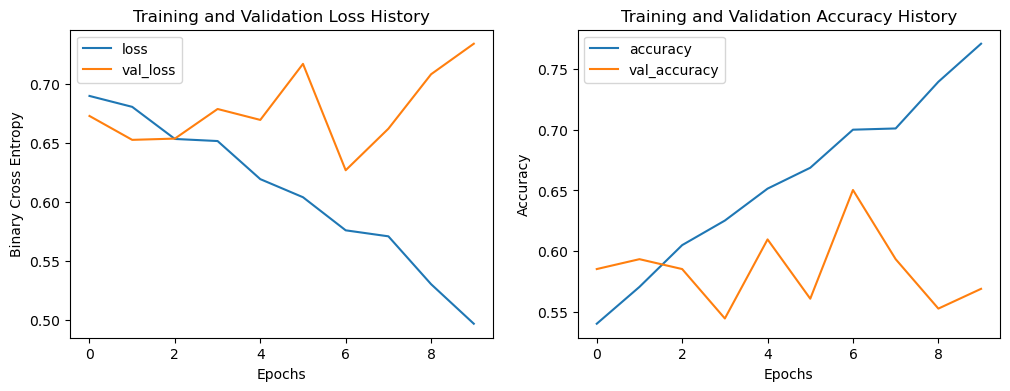

In [14]:
#visualize performance over training 
plot_performance(history_model_1)

              precision    recall  f1-score   support

           0       0.37      0.51      0.43        53
           1       0.46      0.32      0.38        68

    accuracy                           0.40       121
   macro avg       0.41      0.42      0.40       121
weighted avg       0.42      0.40      0.40       121



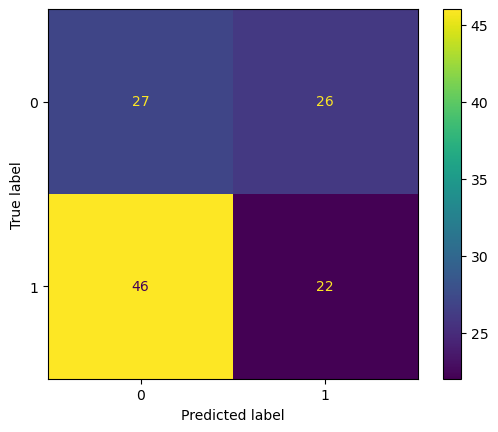

In [15]:
#dig into test performance more
binary_cm_cr(test_generator, model_1)

Different iterations of increasing the model's complexity resulted in declining performance. In this example, our test accuracy fell to 40%. The model is still overfit, with random fluctuations in its validation performance. Based on the outcome of the confusion matrix, we can see that the model is just as likely to classify a dementia patient as normal as it is to classify demented. 

## Model 2

My hypothesis is that the RAW images contain a lot of noise that makes the patterns in the pictures difficult to pick up. In this iteration, I will add a gaussian filter to the data generators to smooth out some of the noise. A gaussian filter replaces pixel values with the weighted average of its neighboring pixels to create finer details.

In [16]:
#Define a function to apply gaussian filter
def gaussian_filter(img):
    filtered_img = cv2.GaussianBlur(img, (5, 5), 0) #used trial and error to determine the best filter size 
    if len(filtered_img.shape) == 3 and filtered_img.shape[2] == 3: # check if the input image is in RGB format
        filtered_img = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2GRAY)
    filtered_img = np.expand_dims(filtered_img, axis=-1)  # add an additional dimension for the grayscale channel
    return filtered_img

#identify paths for train, validation and test sets
train_path = '/Users/mike/Brain_MRI/New Train'
val_path = '/Users/mike/Brain_MRI/New Validation'
test_path = '/Users/mike/Brain_MRI/New Test'

#generate image arrays and labels for train, validation and test using ImageDataGenerator. Include filter in each

#train includes data augmentation with horizontal flip and random rotation 
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip = True, rotation_range = 20, preprocessing_function=gaussian_filter)
train_generator = train_datagen.flow_from_directory(train_path, target_size =(256,256), batch_size = 32,
                                                   class_mode = 'binary', color_mode='grayscale')

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function = gaussian_filter)
test_generator = test_datagen.flow_from_directory(test_path, target_size =(256,256), batch_size = 32,
                                                  class_mode= 'binary', shuffle = False, color_mode='grayscale')

val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function = gaussian_filter)
val_generator = train_datagen.flow_from_directory(val_path, target_size =(256,256), batch_size = 32,
                                                  class_mode= 'binary', shuffle = False, color_mode='grayscale')

Found 990 images belonging to 2 classes.
Found 121 images belonging to 2 classes.
Found 123 images belonging to 2 classes.


In [17]:
model_2 = Sequential()


# add the input layer  
model_2.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(256, 256, 1)))

model_2.add(MaxPooling2D(pool_size=(2, 2)))

# add the second convolutional layer
model_2.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu'))


model_2.add(MaxPooling2D(pool_size=(2, 2)))

# add the third convolutional layer
model_2.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu'))


model_2.add(MaxPooling2D(pool_size=(2, 2)))

# add the fourth convolutional layer
model_2.add(Conv2D(filters=16,
                        kernel_size=(3, 3),
                        activation='relu'))


model_2.add(MaxPooling2D(pool_size=(2, 2)))


# connect all nodes with dense layers. output for binary classification
model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(.5))
model_2.add(Dense(1, activation='sigmoid'))

#use early stopping to help prevent overfitting 
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_2.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
history_model_2 = model_2.fit(train_generator, validation_data = val_generator, epochs = 10, verbose = 1, callbacks = [early_stopping])

Epoch 1/10
31/31 [==============================] - 5s 157ms/step - loss: 0.6959 - accuracy: 0.5273 - val_loss: 0.6942 - val_accuracy: 0.4634
Epoch 2/10
31/31 [==============================] - 4s 114ms/step - loss: 0.6907 - accuracy: 0.5545 - val_loss: 0.6856 - val_accuracy: 0.5854
Epoch 3/10
31/31 [==============================] - 4s 114ms/step - loss: 0.6803 - accuracy: 0.5646 - val_loss: 0.6689 - val_accuracy: 0.6016
Epoch 4/10
31/31 [==============================] - 4s 118ms/step - loss: 0.6541 - accuracy: 0.6323 - val_loss: 0.6345 - val_accuracy: 0.6667
Epoch 5/10
31/31 [==============================] - 4s 114ms/step - loss: 0.6324 - accuracy: 0.6687 - val_loss: 0.6502 - val_accuracy: 0.5854
Epoch 6/10
31/31 [==============================] - 4s 115ms/step - loss: 0.6154 - accuracy: 0.6909 - val_loss: 0.6064 - val_accuracy: 0.6748
Epoch 7/10
31/31 [==============================] - 4s 114ms/step - loss: 0.5902 - accuracy: 0.6909 - val_loss: 0.6437 - val_accuracy: 0.6504
Epoch 

In [18]:
#evaluate performance on test data
test_evaluation(test_generator, model_2)

4/4 [==============================] - 0s 54ms/step - loss: 0.8490 - accuracy: 0.5537
Test loss: 0.8490206003189087 
Test accuracy: 0.5537190437316895


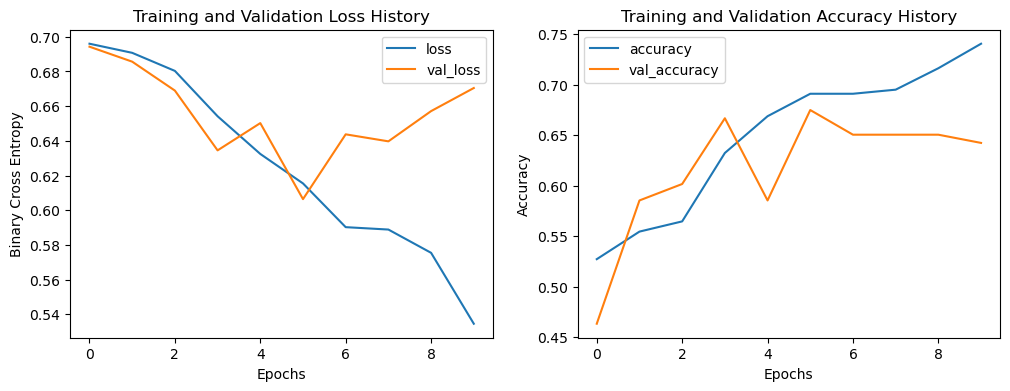

In [19]:
#visualize performance over training 
plot_performance(history_model_2)

              precision    recall  f1-score   support

           0       0.49      0.36      0.41        53
           1       0.59      0.71      0.64        68

    accuracy                           0.55       121
   macro avg       0.54      0.53      0.53       121
weighted avg       0.54      0.55      0.54       121



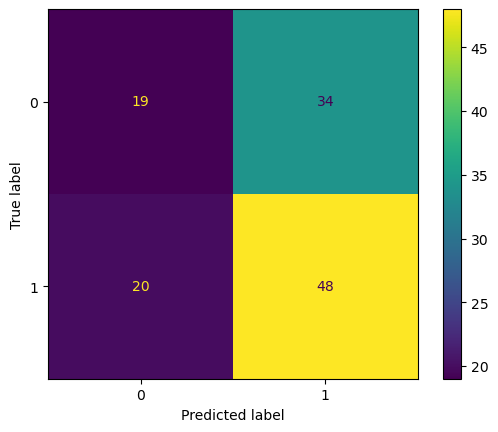

In [20]:
#dig into test performance more
binary_cm_cr(test_generator, model_2)

Adding the gaussian filter increased the test accuracy up to 55% and reduced loss to .78, although the confusion matrix shows the model has actually gotten worse at identifying dementia among actual dementia patients (decline in F1 score). Validation accuracy continues to show a random pattern of fluctuation, which could be attributable to overfitting to the training data. The training and validation loss are in sync up until the 5th epoch, at which point they diverge. In the next model, I will attempt to add regularization to address both these issues.

## Model 3 

In this model iteration, I will add L2 regularization to the model to improve the overfitting as well as batch normalization to improve stability.

In [21]:
model_3 = Sequential()


# add the input layer  
model_3.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(256, 256, 1),
     kernel_regularizer = tf.keras.regularizers.l2(.001)))


model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# add the second convolutional layer
model_3.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
     kernel_regularizer = tf.keras.regularizers.l2(.001)))


model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# add the third convolutional layer
model_3.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu'))


model_3.add(MaxPooling2D(pool_size=(2, 2)))

# add the fourth convolutional layer
model_3.add(Conv2D(filters=16,
                        kernel_size=(3, 3),
                        activation='relu'))


model_3.add(MaxPooling2D(pool_size=(2, 2)))


# connect all nodes with dense layers. output for binary classification
model_3.add(Flatten())
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(.5))
model_3.add(Dense(1, activation='sigmoid'))

#use early stopping to help prevent overfitting 
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_3.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
history_model_3 = model_3.fit(train_generator, batch_size = 10, validation_data = val_generator, epochs = 10, verbose = 1, callbacks = [early_stopping])

Epoch 1/10
31/31 [==============================] - 11s 224ms/step - loss: 1.3405 - accuracy: 0.5111 - val_loss: 0.7326 - val_accuracy: 0.4228
Epoch 2/10
31/31 [==============================] - 5s 171ms/step - loss: 0.7238 - accuracy: 0.5657 - val_loss: 0.7266 - val_accuracy: 0.5854
Epoch 3/10
31/31 [==============================] - 5s 163ms/step - loss: 0.7011 - accuracy: 0.5838 - val_loss: 0.7245 - val_accuracy: 0.5854
Epoch 4/10
31/31 [==============================] - 6s 192ms/step - loss: 0.6900 - accuracy: 0.6303 - val_loss: 0.7343 - val_accuracy: 0.4146
Epoch 5/10
31/31 [==============================] - 5s 168ms/step - loss: 0.6456 - accuracy: 0.6778 - val_loss: 0.7967 - val_accuracy: 0.4146
Epoch 6/10
31/31 [==============================] - 5s 169ms/step - loss: 0.6277 - accuracy: 0.6879 - val_loss: 0.8016 - val_accuracy: 0.4146
Epoch 7/10
31/31 [==============================] - 5s 175ms/step - loss: 0.5910 - accuracy: 0.7131 - val_loss: 0.7231 - val_accuracy: 0.4715


In [22]:
#evaluate performance on test data
test_evaluation(test_generator, model_3)

4/4 [==============================] - 0s 81ms/step - loss: 0.7274 - accuracy: 0.4298
Test loss: 0.727449893951416 
Test accuracy: 0.4297521114349365


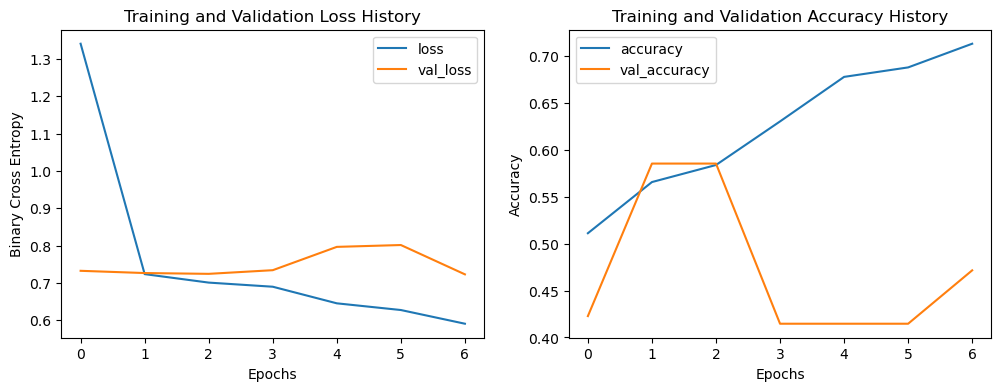

In [23]:
#visualize performance over training 
plot_performance(history_model_3)

              precision    recall  f1-score   support

           0       0.42      0.83      0.56        53
           1       0.47      0.12      0.19        68

    accuracy                           0.43       121
   macro avg       0.45      0.47      0.37       121
weighted avg       0.45      0.43      0.35       121



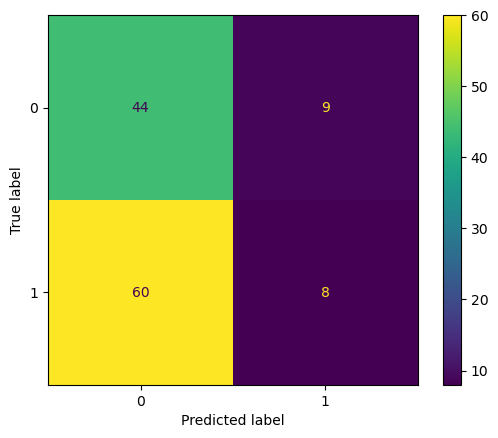

In [24]:
#dig into test performance more
binary_cm_cr(test_generator, model_3)

Over many iterations of the hyperparameters, regularization proved to show little improvement on the nonregularized results. Even very little regularization would result in the validation getting stuck at a local minimum. 

## Model 4 

In this model, I will use transfer learning and apply the pretrained model VGG16 to see if there is any improved performance.

In [29]:
#VGG16 requies RGB images in order to run. I will remove the requirements from my filter changing images back to grayscale 

#Define a function to apply gaussian filter
def gaussian_filter(img):
    filtered_img = cv2.GaussianBlur(img, (5, 5), 0) #used trial and error to determine the best filter size 
    return filtered_img

#identify paths for train, validation and test sets
train_path = '/Users/mike/Brain_MRI/New Train'
val_path = '/Users/mike/Brain_MRI/New Validation'
test_path = '/Users/mike/Brain_MRI/New Test'

#generate image arrays and labels for train, validation and test using ImageDataGenerator

#train includes data augmentation with horizontal flip and random rotation 
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip = True, rotation_range = 20, preprocessing_function=gaussian_filter)
train_generator = train_datagen.flow_from_directory(train_path, target_size =(256,256), batch_size = 32,
                                                   class_mode = 'binary', color_mode='rgb')

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function = gaussian_filter)
test_generator = test_datagen.flow_from_directory(test_path, target_size =(256,256), batch_size = 32,
                                                  class_mode= 'binary', shuffle = False, color_mode='rgb')

val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function = gaussian_filter)
val_generator = train_datagen.flow_from_directory(val_path, target_size =(256,256), batch_size = 32,
                                                  class_mode= 'binary', shuffle = False, color_mode='rgb')

Found 990 images belonging to 2 classes.
Found 121 images belonging to 2 classes.
Found 123 images belonging to 2 classes.


In [30]:
# Load the VGG16 model with the top layer left out
vgg_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the convolutional base
vgg_model.trainable = False

# create model 4
model_4 = Sequential()

# add VGG to model 4 along with our dense layer and output layer
model_4.add(vgg_model)
model_4.add(Flatten())
model_4.add(Dense(512, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(1, activation='sigmoid'))

#use early stopping to help prevent overfitting 
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_model_4 = model_4.fit(train_generator, validation_data = val_generator, epochs = 10, verbose = 1, callbacks = [early_stopping])

Epoch 1/10
31/31 [==============================] - 13s 406ms/step - loss: 2.5832 - accuracy: 0.5182 - val_loss: 0.7174 - val_accuracy: 0.4715
Epoch 2/10
31/31 [==============================] - 12s 388ms/step - loss: 0.7030 - accuracy: 0.5828 - val_loss: 0.6596 - val_accuracy: 0.6585
Epoch 3/10
31/31 [==============================] - 12s 393ms/step - loss: 0.6507 - accuracy: 0.6162 - val_loss: 0.6462 - val_accuracy: 0.6260
Epoch 4/10
31/31 [==============================] - 12s 390ms/step - loss: 0.6339 - accuracy: 0.6697 - val_loss: 0.6323 - val_accuracy: 0.6341
Epoch 5/10
31/31 [==============================] - 12s 388ms/step - loss: 0.6173 - accuracy: 0.6636 - val_loss: 0.6150 - val_accuracy: 0.6911
Epoch 6/10
31/31 [==============================] - 12s 388ms/step - loss: 0.5832 - accuracy: 0.7061 - val_loss: 0.6147 - val_accuracy: 0.6260
Epoch 7/10
31/31 [==============================] - 12s 386ms/step - loss: 0.5635 - accuracy: 0.7152 - val_loss: 0.5860 - val_accuracy: 0.7967

In [31]:
#evaluate performance on test data
test_evaluation(test_generator, model_4)

4/4 [==============================] - 1s 335ms/step - loss: 0.7341 - accuracy: 0.4298
Test loss: 0.7340839505195618 
Test accuracy: 0.4297521114349365


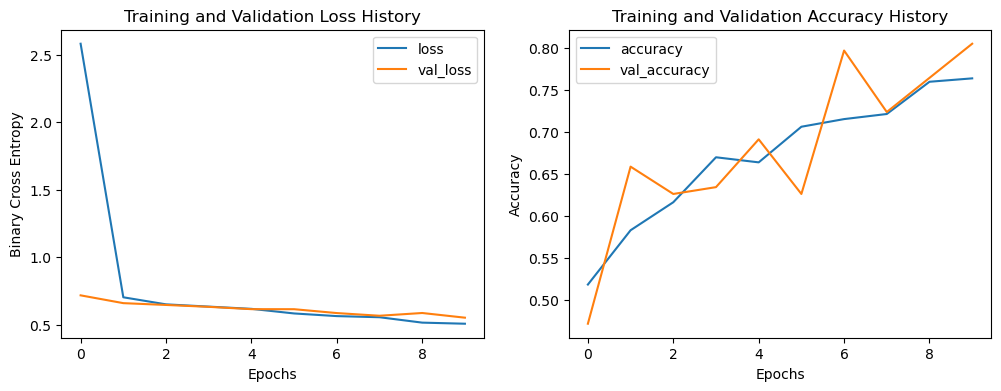

In [38]:
#visualize performance over training 
plot_performance(history_model_4)

              precision    recall  f1-score   support

           0       0.39      0.57      0.46        53
           1       0.48      0.31      0.38        68

    accuracy                           0.42       121
   macro avg       0.43      0.44      0.42       121
weighted avg       0.44      0.42      0.41       121



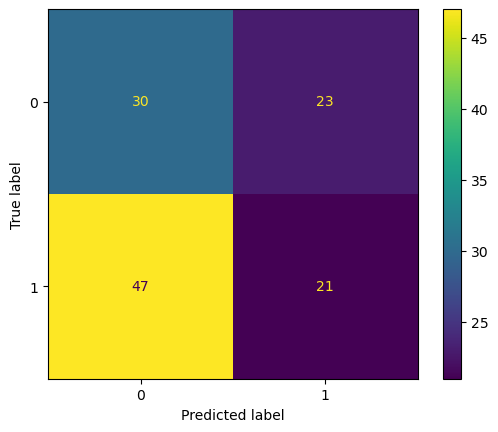

In [39]:
#dig into test performance more
binary_cm_cr(test_generator, model_4)

VGG16 performs no better than our best model. I will declare model 2 my best RAW model and move on to the preprocessed images. Based on the performance of the RAW models, I believe the quality of the images is holding the models back. We will see how the same models perform with the preprocessed data.

# Section 2 - Preprocessed MRI

Preprocessing an MRI can involve a number of steps including skull stripping, bias field correction, segmenting the brain structures, and many other techniques. This process allows doctors and technicians to isolate the portions of the brain most affected by neurodegenerative diseases. In this section, I will use similar models to the RAW section to see if there is an increase in performance.

## Data Visualization

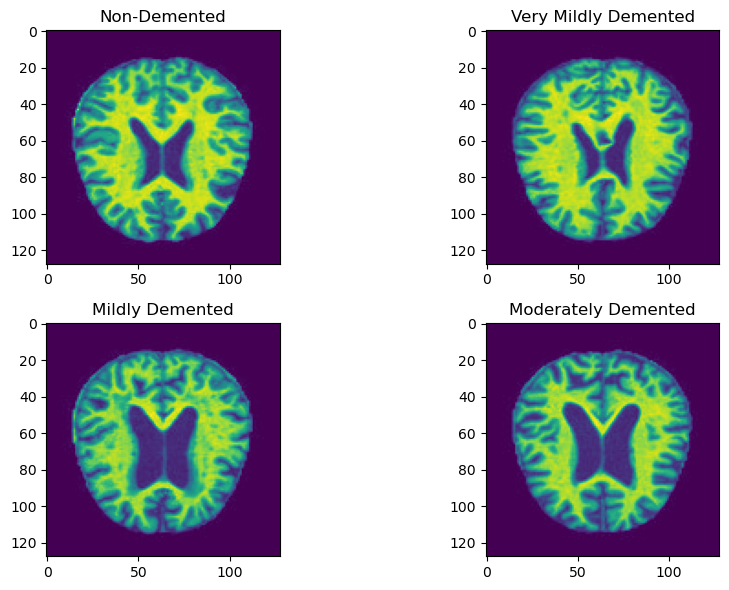

In [12]:
#establish filepaths for sample images
nondemented_img = Image.open('/Users/mike/Brain_MRI/Processed_MRI_Train/Non_Demented/non_2.jpg')
very_mildly_demented_img = Image.open('/Users/mike/Brain_MRI/Processed_MRI_Train/Very_Mild_Demented/verymild_2.jpg')
mildly_demented_img = Image.open('/Users/mike/Brain_MRI/Processed_MRI_Train/Mild_Demented/mild_2.jpg')
moderately_demented_img = Image.open('/Users/mike/Brain_MRI/Processed_MRI_Train/Moderate_Demented/moderate_3.jpg')

#plot each image with the appropriate title
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,6))
ax[0,0].imshow(nondemented_img)
ax[0,0].set_title('Non-Demented')
ax[0,1].imshow(very_mildly_demented_img)
ax[0,1].set_title('Very Mildly Demented')
ax[1,0].imshow(mildly_demented_img)
ax[1,0].set_title('Mildly Demented')
ax[1,1].imshow(moderately_demented_img)
ax[1,1].set_title('Moderately Demented')
plt.tight_layout();

## Train-Test-Validation Split

The original dataset included 6,400 images of preprocessed MRIs collected from the Alzheimer’s Disease Neuroimaging Initiative (ADNI) and provided via Kaggle (https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset). Staying consistent with the RAW MRI modeling process, 10% of images were used for the validation set and 10% were used for the test set. The remainder was used for training. 


In [4]:
#file paths for image folders
train_path = '/Users/mike/Brain_MRI/Processed_MRI_Train'
test_path = '/Users/mike/Brain_MRI/Processed_MRI_Test'
val_path = '/Users/mike/Brain_MRI/Processed_MRI_Validation'

#generate image arrays and labels for train, validation and test sets

#random horizontal flip implemented in the training set for augmentation
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip = True)
train_generator = train_datagen.flow_from_directory(train_path, target_size =(128,128), batch_size = 32,
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path, target_size =(128,128), batch_size = 32,
                                                  class_mode= 'categorical', shuffle = False)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(val_path, target_size =(128,128), batch_size = 32,
                                                  class_mode= 'categorical', shuffle = False )

Found 5187 images belonging to 4 classes.
Found 639 images belonging to 4 classes.
Found 574 images belonging to 4 classes.


In [5]:
#confirm class labels
class_indices = train_generator.class_indices
class_indices

{'Mild_Demented': 0,
 'Moderate_Demented': 1,
 'Non_Demented': 2,
 'Very_Mild_Demented': 3}

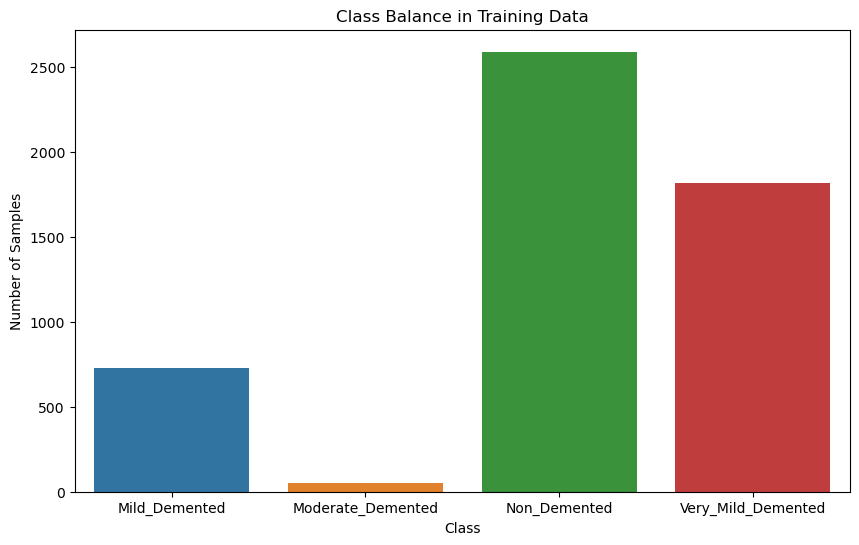

In [10]:
# Get the number of samples for each class 
num_samples = []
for key in class_indices.keys():
    num_samples.append(len(train_generator.labels[train_generator.labels==class_indices[key]]))

# Create a bar chart to visualize the class balance
plt.figure(figsize=(10,6))
sns.barplot(x=list(class_indices.keys()), y=num_samples)
plt.title('Class Balance in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show();

## Baseline Model

In [31]:
#instantiate a model
baseline_model_pp = Sequential()


# add the input layer  
baseline_model_pp.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

baseline_model_pp.add(MaxPooling2D(pool_size=(2, 2)))

# add the second convolutional layer
baseline_model_pp.add(Conv2D(filters=16,
                        kernel_size=(3, 3),
                        activation='relu'))

baseline_model_pp.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers. output for binary classification
baseline_model_pp.add(Flatten())
baseline_model_pp.add(Dense(512, activation='relu'))
baseline_model_pp.add(Dense(4, activation='softmax'))

#use early stopping to help prevent overfitting 
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
baseline_model_pp.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
history_base_pp = baseline_model_pp.fit(train_generator, validation_data = val_generator, epochs = 10, verbose = 1, callbacks = [early_stopping])

Epoch 1/10
163/163 [==============================] - 4s 24ms/step - loss: 1.0024 - accuracy: 0.5317 - val_loss: 0.9386 - val_accuracy: 0.5174
Epoch 2/10
163/163 [==============================] - 4s 22ms/step - loss: 0.8167 - accuracy: 0.6125 - val_loss: 0.8015 - val_accuracy: 0.6498
Epoch 3/10
163/163 [==============================] - 3s 21ms/step - loss: 0.6467 - accuracy: 0.7122 - val_loss: 0.6103 - val_accuracy: 0.7561
Epoch 4/10
163/163 [==============================] - 3s 21ms/step - loss: 0.5071 - accuracy: 0.7841 - val_loss: 0.5097 - val_accuracy: 0.7648
Epoch 5/10
163/163 [==============================] - 3s 21ms/step - loss: 0.3907 - accuracy: 0.8367 - val_loss: 0.4219 - val_accuracy: 0.8066
Epoch 6/10
163/163 [==============================] - 3s 21ms/step - loss: 0.2592 - accuracy: 0.9053 - val_loss: 0.2683 - val_accuracy: 0.8885
Epoch 7/10
163/163 [==============================] - 3s 21ms/step - loss: 0.1855 - accuracy: 0.9318 - val_loss: 0.2961 - val_accuracy: 0.8746

In [32]:
#evaluate performance on test data
test_evaluation(test_generator, baseline_model_pp)

20/20 [==============================] - 0s 13ms/step - loss: 0.1254 - accuracy: 0.9687
Test loss: 0.12539079785346985 /n Test accuracy: 0.9687010645866394


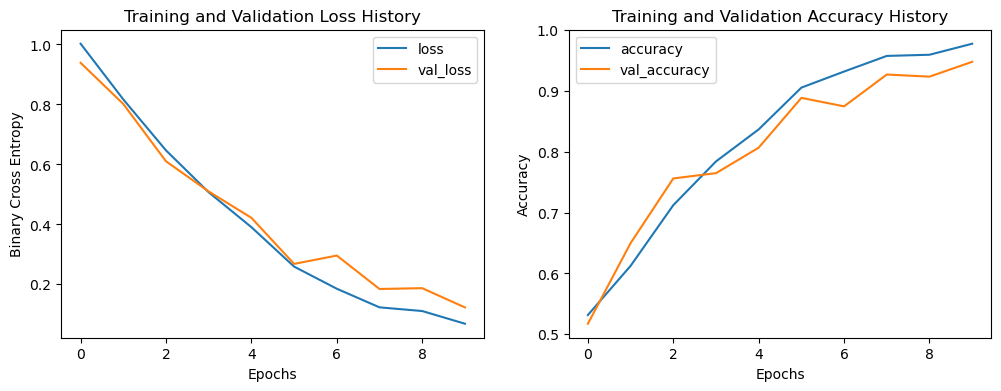

In [33]:
#visualize performance over training 
plot_performance(history_base_pp)

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        89
           1       1.00      1.00      1.00         6
           2       0.97      0.98      0.97       320
           3       0.96      0.96      0.96       224

    accuracy                           0.97       639
   macro avg       0.98      0.97      0.98       639
weighted avg       0.97      0.97      0.97       639



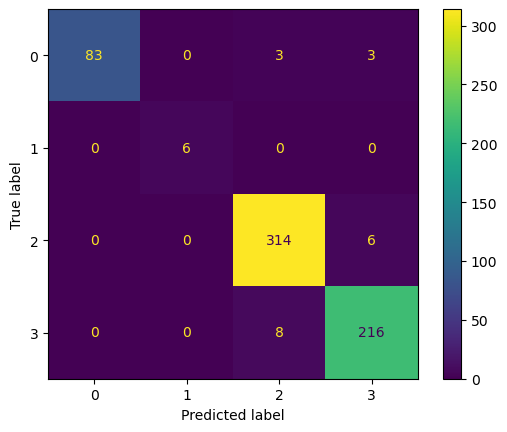

In [34]:
#dig into test performance more
multicat_cm_cr(test_generator, baseline_model_pp)

Baseline results demonstrate the impact of preprocessing on the the model's predictive capabilities. The same model architecture as the RAW data baseline is 96.8% accurate on the test data with a categorical cross entropy loss of .13. The most common error in the model is confusing mild and very mild dementia  for no dementia and vice versa. As the condtion progresses, however, it is more and more evident in the MRI scans as shown by the perfect percision and recall scores for the moderate dementia images. This is despite a large class imbalance against the moderate class.

## Model 1 

In the last model, there was a still a slight amount of overfitting that I will attempt to correct by adding in a Dropout after my dense layer.

In [35]:
#instantiate a model
model_1_pp = Sequential()


# add the input layer  
model_1_pp.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

model_1_pp.add(MaxPooling2D(pool_size=(2, 2)))

# add the second convolutional layer
model_1_pp.add(Conv2D(filters=16,
                        kernel_size=(3, 3),
                        activation='relu'))

model_1_pp.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers. output for binary classification
model_1_pp.add(Flatten())
model_1_pp.add(Dense(512, activation='relu'))
model_1_pp.add(Dropout(.5))
model_1_pp.add(Dense(4, activation='softmax'))

#use early stopping to help prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_1_pp.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
history_model_1_pp= model_1_pp.fit(train_generator, validation_data = val_generator, epochs = 20, verbose = 1, callbacks = [early_stopping])

Epoch 1/20
163/163 [==============================] - 4s 23ms/step - loss: 1.0316 - accuracy: 0.5171 - val_loss: 0.9253 - val_accuracy: 0.5575
Epoch 2/20
163/163 [==============================] - 3s 21ms/step - loss: 0.8469 - accuracy: 0.6069 - val_loss: 0.8220 - val_accuracy: 0.6272
Epoch 3/20
163/163 [==============================] - 3s 21ms/step - loss: 0.7399 - accuracy: 0.6570 - val_loss: 0.8013 - val_accuracy: 0.6551
Epoch 4/20
163/163 [==============================] - 3s 21ms/step - loss: 0.6385 - accuracy: 0.7143 - val_loss: 0.5967 - val_accuracy: 0.7282
Epoch 5/20
163/163 [==============================] - 3s 21ms/step - loss: 0.4962 - accuracy: 0.7904 - val_loss: 0.4819 - val_accuracy: 0.8066
Epoch 6/20
163/163 [==============================] - 3s 21ms/step - loss: 0.4242 - accuracy: 0.8249 - val_loss: 0.4839 - val_accuracy: 0.7997
Epoch 7/20
163/163 [==============================] - 3s 21ms/step - loss: 0.3125 - accuracy: 0.8768 - val_loss: 0.4163 - val_accuracy: 0.8258

In [39]:
#evaluate performance on test data
test_evaluation(test_generator, model_1_pp)

20/20 [==============================] - 0s 11ms/step - loss: 0.0821 - accuracy: 0.9671
Test loss: 0.08210176229476929 
Test accuracy: 0.9671361446380615


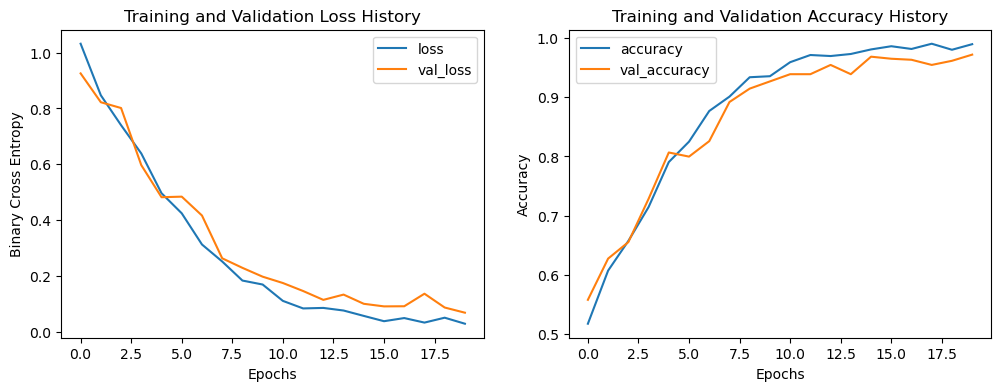

In [45]:
#visualize performance over training 
plot_performance(history_model_1_pp)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        89
           1       1.00      0.83      0.91         6
           2       0.99      0.96      0.97       320
           3       0.95      0.97      0.96       224

    accuracy                           0.97       639
   macro avg       0.97      0.94      0.95       639
weighted avg       0.97      0.97      0.97       639



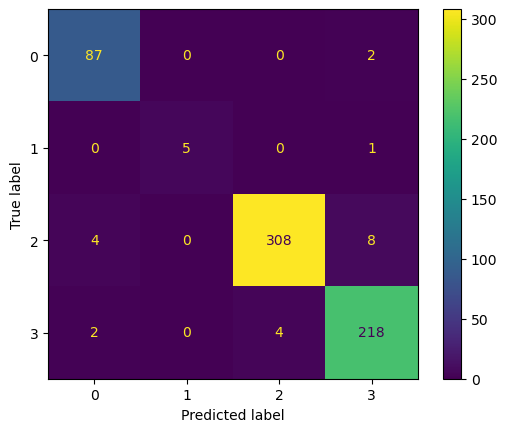

In [46]:
#dig into test performance more
multicat_cm_cr(test_generator, model_1_pp)

Adding .5 dropout below the dense layer improves the overfitting and lowers test loss down to .08 while maintaining the same accuracy as the baseline.

## Model 2

In this iteration, I will add a learning rate schedule to decrease the learning rate when validation loss begins to stagnate. A lower learning rate enables the model to make more precise adjustments to its parameters and reduces the chances it misses optimal values. Based on the last model's run, it seems training seems to stagnate towards the end which makes me think decreasing the learning rate at the end may help the model unlock an extra bit of performance.

In [40]:
#instantiate a model
model_2_pp = Sequential()


# add the input layer  
model_2_pp.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 3)))

model_2_pp.add(MaxPooling2D(pool_size=(2, 2)))

# add the second convolutional layer
model_2_pp.add(Conv2D(filters=16,
                        kernel_size=(3, 3),
                        activation='relu'))

model_2_pp.add(MaxPooling2D(pool_size=(2, 2)))

# connect all nodes with dense layers. output for binary classification
model_2_pp.add(Flatten())
model_2_pp.add(Dense(512, activation='relu'))
model_2_pp.add(Dropout(.5))
model_2_pp.add(Dense(4, activation='softmax'))

#use early stopping to help prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

#this function will reduce the learning rate by a factor of ten when the val_loss stagnates for more than 2 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)


#using adam optimizer, binary_crossentropy to measure loss and accuracy as our metric  
model_2_pp.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
history_model_2_pp= model_2_pp.fit(train_generator, validation_data = val_generator, epochs = 30, verbose = 1, callbacks = [early_stopping, reduce_lr])

Epoch 1/30
163/163 [==============================] - 4s 23ms/step - loss: 1.0495 - accuracy: 0.4972 - val_loss: 0.9175 - val_accuracy: 0.5105 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 4s 21ms/step - loss: 0.8779 - accuracy: 0.5836 - val_loss: 0.8103 - val_accuracy: 0.6202 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - 4s 21ms/step - loss: 0.7493 - accuracy: 0.6584 - val_loss: 0.7666 - val_accuracy: 0.6202 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 4s 22ms/step - loss: 0.6084 - accuracy: 0.7341 - val_loss: 0.6037 - val_accuracy: 0.7456 - lr: 0.0010
Epoch 5/30
163/163 [==============================] - 3s 21ms/step - loss: 0.5069 - accuracy: 0.7904 - val_loss: 0.5261 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 6/30
163/163 [==============================] - 3s 21ms/step - loss: 0.4057 - accuracy: 0.8321 - val_loss: 0.5340 - val_accuracy: 0.7840 - lr: 0.0010
Epoch 7/30
163/163 [==============================] - 3s 21ms/st

In [41]:
#evaluate performance on test data
test_evaluation(test_generator, model_2_pp)

20/20 [==============================] - 0s 13ms/step - loss: 0.0537 - accuracy: 0.9890
Test loss: 0.05372151359915733 
Test accuracy: 0.9890453815460205


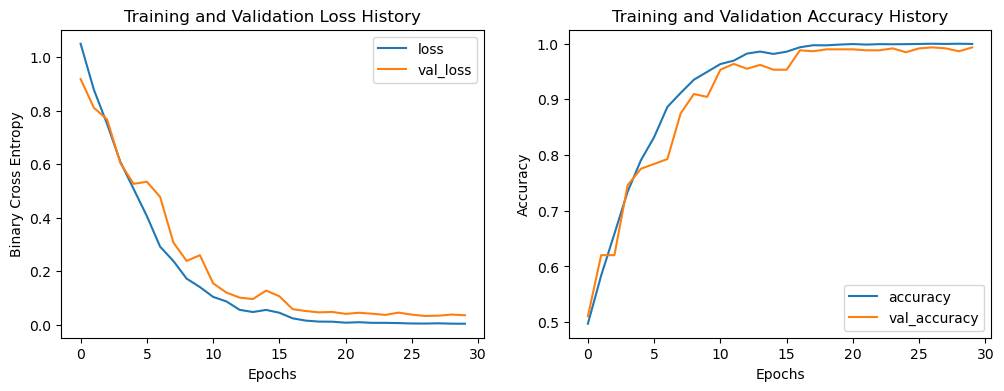

In [42]:
#visualize performance over training 
plot_performance(history_model_2_pp)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        89
           1       1.00      1.00      1.00         6
           2       0.99      0.99      0.99       320
           3       0.98      0.99      0.99       224

    accuracy                           0.99       639
   macro avg       0.99      0.99      0.99       639
weighted avg       0.99      0.99      0.99       639



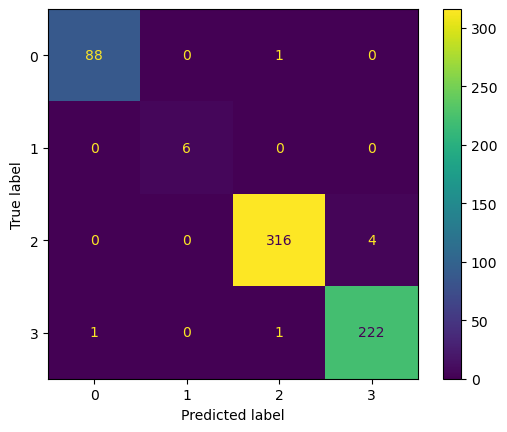

In [43]:
#dig into test performance more
multicat_cm_cr(test_generator, model_2_pp)

The lower learning rate improved the model performance, increasing the accuracy score to 98.9% and reducing loss to .054. Based on the confusion matrix, we can see a clear improvement in the ability to classify edge cases between non-demented and mildly demented patients. I will call this model my best and final model and move on to the conclusion.

## Conclusion

Our modeling process showed that MRI images can be used to identify dementia, including early stages of dementia, with high accuracy. In order to do so, the MRI images will need to be preprocessed similar the ADNI data used here. Due to time constraints, we were not able to find a way to replicate the preprocessed MRI success with the RAW data. As next steps, I would like to explore using 3D Conv layers to analyze the entire 128 slice nifti image at once rather than extracting individual 2D slices.  